In [1]:
import sys
import dotenv
import os
dotenv.load_dotenv()
sys.path.append(os.getenv('MAINDIR'))
from helpers.ds_helpers import X_y_split, open_and_prepare_df
from helpers.models_helpers import random_seeds, plot_results
import tensorflow as tf
import numpy as np
from scipy import stats
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error


warnings.filterwarnings("ignore", category=UserWarning)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-04-25 14:07:18.254004: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 14:07:18.277926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 14:07:18.614027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-04-25 14:07:19.207253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 14:07:19.237770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 14:07:19.237844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Manual parameters search

In [2]:
X, y = X_y_split(open_and_prepare_df('features'), 'nlp_all')

In [3]:
def create_model():
    random_seeds()
    keras_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(300, activation='sigmoid'),
                        tf.keras.layers.Dense(150, activation='LeakyReLU'),
                        tf.keras.layers.Dense(64, activation='LeakyReLU'),
                        
                        tf.keras.layers.Dense(units=1, activation='selu')
                        ])

    keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.85), loss='mean_absolute_error')
    return keras_model

In [4]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)

keras_predictions = []
y_main_true = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_model()
    model.fit(X_train, y_train, batch_size=70, epochs=150, verbose=0)
    keras_prediction = model.predict(X_test, verbose=0).flatten()

    keras_predictions = np.concatenate((keras_predictions, keras_prediction))
    y_main_true = np.concatenate((y_main_true, y_test))
    print(stats.pearsonr(keras_prediction, y_test))
    
stats.pearsonr(y_main_true, keras_predictions)

2023-04-25 14:07:19.674035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 14:07:19.674126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 14:07:19.674165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

PearsonRResult(statistic=0.53708459068401, pvalue=0.0001706678234100776)
PearsonRResult(statistic=0.6588916996721852, pvalue=1.1581625400253193e-06)
PearsonRResult(statistic=0.5896799400565396, pvalue=2.5308455557557764e-05)
PearsonRResult(statistic=0.3529893503604631, pvalue=0.020244024301240768)
PearsonRResult(statistic=0.5157100388659452, pvalue=0.0004011083425595137)
PearsonRResult(statistic=0.414513748221218, pvalue=0.005717043628399299)
PearsonRResult(statistic=0.5892162577122423, pvalue=3.225650189245561e-05)
PearsonRResult(statistic=0.5122432771162215, pvalue=0.0004455599701606681)
PearsonRResult(statistic=0.5393107630370705, pvalue=0.00019018081750803774)
PearsonRResult(statistic=0.42409735524342257, pvalue=0.004594470510962447)


PearsonRResult(statistic=0.5024674591305064, pvalue=4.4355314175007846e-29)

Best model eval

In [5]:
df = open_and_prepare_df('features')
x_strings = ['nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_all']

In [6]:
for x_string in x_strings:
    X, y = X_y_split(df, x_string)

    keras_predictions = []
    y_main_true = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_model()
        model.fit(X_train, y_train, batch_size=70, epochs=150, verbose=0)
        keras_prediction = model.predict(X_test, verbose=0).flatten()

        keras_predictions = np.concatenate((keras_predictions, keras_prediction))
        y_main_true = np.concatenate((y_main_true, y_test))
    
    print(x_string)
    print(stats.pearsonr(y_main_true, keras_predictions))
    print(mean_absolute_error(y_main_true, keras_predictions))

nlp_2
PearsonRResult(statistic=0.29612647880740267, pvalue=3.2636326056459346e-10)
2.791292697122411
nlp_3
PearsonRResult(statistic=0.3632445545387747, pvalue=5.9517143759362854e-15)
2.570983189633482
nlp_4
PearsonRResult(statistic=0.25217409285269543, pvalue=1.0466814995302748e-07)
2.76524205350986
nlp_5
PearsonRResult(statistic=0.36285063631402303, pvalue=6.396328168853002e-15)
2.600450919351732
nlp_all
PearsonRResult(statistic=0.5031305685227736, pvalue=3.654766032392923e-29)
2.4032309633479656


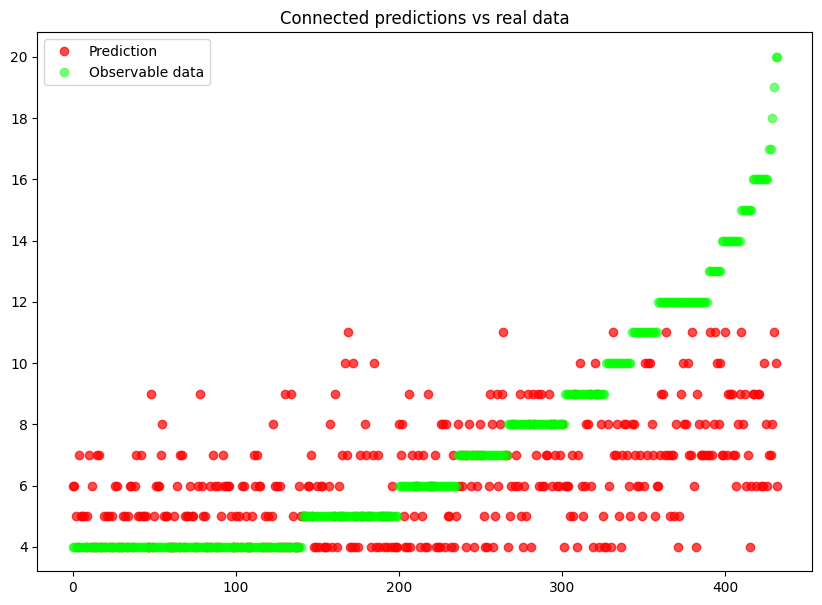

In [7]:
plot_results(keras_predictions, y_main_true)